In [1]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 
import random
import ast
import html
import re
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm
#np.set_printoptions(threshold=np.inf) #set to print full output
import numpy as np
random.seed(42)
#os.chdir('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline')
import sys
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModel  # Import AutoTokenizer and AutoModel
import nltk
nltk.download('stopwords')

#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

2025-02-12 16:49:15.193794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 16:49:15.233035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 16:49:15.233722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 16:49:16.133473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ll16598/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
model_name='all-MiniLM-L6-v2'
sentence_model = SentenceTransformer(model_name)  # or any SBERT model from Hugging Face
#THIS IS A MULTILINGUAL SEMANTIC SIMILARITY MODEL
# Load the model and tokenizer
model_name = 'sentence-transformers/'+model_name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
save_directory = './BERT_models/all-MiniLM-L6-v2'

# Save model and tokenizer\
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./BERT_models/all-MiniLM-L6-v2/tokenizer_config.json',
 './BERT_models/all-MiniLM-L6-v2/special_tokens_map.json',
 './BERT_models/all-MiniLM-L6-v2/vocab.txt',
 './BERT_models/all-MiniLM-L6-v2/added_tokens.json',
 './BERT_models/all-MiniLM-L6-v2/tokenizer.json')

In [4]:
def remove_unwanted_tokens(embedding_matrix, all_tokens):
    """
    Remove CLS, SEP, and stopwords from the tokens array and their corresponding embeddings.
    
    Args:
    - embedding_matrix: A NumPy array of shape (num_tokens, embedding_dim).
    - all_tokens: A NumPy array of tokens of shape (num_tokens,).
    
    Returns:
    - filtered_embedding_matrix: A NumPy array of the remaining embeddings.
    - filtered_tokens: A NumPy array of the remaining tokens.
    """

    # Define stopwords and tokens to remove
    stop_words = set(stopwords.words('english'))
    unwanted_tokens = ['[CLS]', '[SEP]', '[PAD]',None]
    # Create a boolean mask of the tokens we want to keep
    mask = np.array([
        token not in unwanted_tokens and token not in stop_words and '#' not in token
        if token is not None else False  # Handle None tokens explicitly
        for token in all_tokens
    ])

    # Apply the mask to both the embedding matrix and the tokens array
    filtered_embedding_matrix = embedding_matrix[mask]
    filtered_tokens = all_tokens[mask]

    return filtered_embedding_matrix, filtered_tokens
def get_embedding_mat(embedding_dir, window_size, step):
    pattern_matrix = rf"^sentence_embedding_matrix_{window_size}_{step}_(\d+)\.pkl$"
    pattern_tokens = rf"^tokens_{window_size}_{step}_(\d+)\.pkl$"

    # Lists to store filenames with captured indices
    matrix_files = []
    token_files = []

    # Populate lists with matching filenames and their indices
    for filename in os.listdir(embedding_dir):
        match_matrix = re.match(pattern_matrix, filename)
        match_tokens = re.match(pattern_tokens, filename)

        if match_matrix:
            index = int(match_matrix.group(1))
            matrix_files.append((index, filename))
        elif match_tokens:
            index = int(match_tokens.group(1))
            token_files.append((index, filename))

    # Sort files by the extracted index in ascending order
    matrix_files.sort()
    token_files.sort()

    # Lists to store loaded data
    corpus_embedding_matrices = []
    corpus_tokens = []

    # Load files in sorted order
    for _, filename in matrix_files:
        with open(os.path.join(embedding_dir, filename), 'rb') as f:
            corpus_embedding_matrices.append(pickle.load(f))

    for _, filename in token_files:
        with open(os.path.join(embedding_dir, filename), 'rb') as f:
            corpus_tokens.append(pickle.load(f))
    corpus_embedding_matrix = np.concatenate(corpus_embedding_matrices, axis=0)
    corpus_token_matrix = np.concatenate(corpus_tokens, axis=0)
    corpus_embedding_matrix, corpus_token_matrix = remove_unwanted_tokens(corpus_embedding_matrix, corpus_token_matrix)
    return corpus_embedding_matrix, corpus_token_matrix

In [5]:
import re

# Define the file path
file_path = '/home/ll16598/Documents/POSTDOC/cleaned_data/cleaned_SER2_monologs.txt'

# Open and read the file as a block of text
with open(file_path, 'r', encoding='utf-8') as file:
    data_monologs = file.read()

# Regular expression to match classification headers like %#CLASSIFICATION#SOME TEXT#
pattern = r'%#([^#]+)#'

# Split the text based on the pattern to separate sections
sections = re.split(pattern, data_monologs)

# Lists to store classifications and corresponding text sections
classification = []
text_blocks = []

# Iterate through the split sections
for i in range(1, len(sections), 2):
    current_section = sections[i].strip()  # Get the section between the hashtags
    corresponding_text = sections[i + 1].strip() if i + 1 < len(sections) else ""  # Get the following text
    
    # Append the classification and corresponding text block
    classification.append(current_section)
    
    # Add corresponding text blocks if they meet the length condition
    if len(corresponding_text) > 20:
        corresponding_text = re.sub(r'^[^#]*#', '', corresponding_text).strip()
        text_blocks.append(corresponding_text)
# Now, classification contains section identifiers, and text_blocks contains corresponding text

# Example output to check the first few entries
for c, t in zip(classification, text_blocks):
    print(f"Classification: {c}")
    print(f"Text Block: {t[:100]}...")  # Print only the first 100 characters of the text for brevity
    print("-" * 50)


Classification: SER202.s3.IPSP
Text Block: uh so this feels a little strange to be talking into this, but um I’m feeling pretty uh that I will ...
--------------------------------------------------
Classification: SER202.s2.Monolog
Text Block: [Noises] All right, so um I’m moderately bummed that Selena just left the room.  Uh I enjoy talking ...
--------------------------------------------------
Classification: SER202.s3.Monolog
Text Block: [Noises] Um all right, so not feeling out of the ordinary at all right now um so a little tired.  I ...
--------------------------------------------------
Classification: SER204.s1.monolog
Text Block: [Noises] This is by far one of the strangest highs I’ve ever had.  Um [deep breath] it feels like uh...
--------------------------------------------------
Classification: SER204.s2.monolog
Text Block: [Beeping] [Noises] I need to go.  I need to run.  I need to run.  I need to run now.  I need to go r...
-------------------------------------------------

In [6]:
import ast
import html
import re

import re
import pandas as pd

def preprocess_text(text):
    # Check if the text is NaN (null), and handle it
    if pd.isna(text):
        return ''
    
    # (1) DO NOT convert to lowercase -> line removed/omitted
    
    # (2) Remove digits (optional — keep or remove depending on your needs)
    # If you do NOT want to remove digits, comment this line out:
    # text = re.sub(r'\d+', '', text)
    
    # (3) Remove all text inside square brackets AND parentheses (including the brackets themselves)
    #    - If there could be nested parentheses/brackets, this regex won't handle nesting properly.
    #    - For simple cases, this works fine.
    text = re.sub(r'\[.*?\]', '', text)  # remove square-bracketed content
    text = re.sub(r'\(.*?\)', '', text)  # remove parenthesized content

    # (4) Replace newline characters with a space
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # (5) Replace multiple dots ("..") with a single space
    #     (Adjust or remove this if you want to preserve repeated dots.)
    text = re.sub(r'\.\.', ' ', text)
    
    # (6) Remove 'rr' when it occurs at the start of a word (based on your original code)
    text = re.sub(r'\brr\w*', '', text)
    
    # (7) PRESERVE punctuation -> so we remove the old line that stripped everything except periods:
    #     text = re.sub(r'[^\w\s\.]', '', text)
    #     ^ Commented out/removed because you want to keep punctuation.

    # (8) Ensure single spacing between words and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+([.,])', r'\1', text)
    # Replace exactly two consecutive periods ".." with a single period "."
    text = re.sub(r'(?<!\.)\.\.(?!\.)', '.', text)

    return text
# Example usage
preprocessed_data = [preprocess_text(str(narrative)) for narrative in text_blocks]


In [7]:
df=pd.DataFrame({'processed_text':preprocessed_data,
                 'classification':classification})
df = df.drop(index=51)

# If you want to reset the index after dropping, you can do this:
df = df.reset_index(drop=True)

In [8]:
def get_sentence_embeddings(sentences):
    embeddings=[]
#    token_embeddings=[]
    for sentence in sentences:
        sentence_embedding = sentence_model.encode(sentence)
        embeddings.append(sentence_embedding)
        print(len(embeddings))
        # 2. Get token embeddings
        # Tokenize the input sentence and obtain token IDs
 #       tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

#         # Pass tokens through the model to get hidden states
#         with torch.no_grad():
#             # Get the hidden states (token embeddings)
#             outputs = model(tokens['input_ids'], attention_mask=tokens['attention_mask'], output_hidden_states=True)
#             token_embedding = outputs['hidden_states'][-1].squeeze()  # (num_tokens, embedding_dim)
#         token_embeddings.append(token_embedding)
    return np.array(embeddings)#, token_embeddings

In [9]:

#example sentences to compute attention-weighted embeddings
sentences = ["This is the first sentence.", "Here is another one."]

# Get attention-weighted embeddings for BERT
embeddings = get_sentence_embeddings(sentences)


1
2


In [10]:
#stop_words = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize
def clean_tokens(tokens):    
    # Filter out stopwords and invalid tokens
    clean_list = [
        token for token in tokens
        if token.isalpha()  # Keep only alphabetic tokens
        and token.lower() not in stop_words  # Remove stopwords
        and not token.startswith("##")  # Remove subword tokens like "##z"
    ]
    return clean_list
def get_most_similar_atoms(sentence_embeddings, atom_vectors):
    most_similar_atoms = []
    for embedding in sentence_embeddings:
        embedding_reshaped = embedding.reshape(1, -1)
        similarities = np.array([cosine_similarity(embedding_reshaped, av.reshape(1, -1)) for av in atom_vectors])
        most_similar_atom_idx = np.argmax(similarities)
        most_similar_atoms.append(most_similar_atom_idx)
    return most_similar_atoms
def get_sentence_embeddings(sentences):
    return np.array([sentence_model.encode(sentence) for sentence in sentences])# Step 1: Split the text into sentences

def split_text_into_sentences(text, min_tokens=1):
    # Initial split by periods
    sentences = text.split('.')
    filtered_sentences = []
    for sentence in sentences:
        # Count tokens in the current sentence
        sentence = sentence.strip()
        #token_count = len(re.findall(r'\w+', sentence))
        words = word_tokenize(sentence)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        token_count = len(filtered_words)
        # Check if current sentence meets the minimum token requirement
        if token_count >= min_tokens:
            # If it does, append to filtered_sentences
            filtered_sentences.append(sentence + ".")
        else:#
            continue
    return filtered_sentences

def split_text_into_windows(text, window_size, step):
    text = re.sub(r'[.!?]', '', text)  # This removes full stops, exclamation marks, and question marks
    words = text.split()
    # Create n-sized windows of words
    windows = [' '.join(words[i:i+window_size]) for i in range(0, len(words) - window_size + 1, \
                                                               step)]
    if len(words) % window_size != 0:
        windows.append(' '.join(words[-window_size:]))
    return windows

def process_texts(df, window='window', windowsize=64, step=4):
    print(f'Using {windowsize}-length windows as steps of {step} tokens')
    sentence_embeddings_column = []
    most_similar_atoms_column = []

    # Wrapping the loop with tqdm for progress tracking
    for text in tqdm(df['processed_text'], desc="Processing texts"):
        # Step 1: Split text into sentences
        if window=='window':
            sentences=split_text_into_windows(text, windowsize, step)
        elif window=='sentences':
            sentences = split_text_into_sentences(text)
        sentence_embeddings=get_sentence_embeddings(sentences)
        most_similar_atoms = get_most_similar_atoms(sentence_embeddings, dictionary)
        most_similar_atoms_column.append(most_similar_atoms)
        sentence_embeddings_column.append(sentence_embeddings)
    df['sentence_embeddings']=sentence_embeddings_column
    df['most_similar_atoms'] = most_similar_atoms_column

    return df


In [11]:
def get_contextual_embeddings_and_tokens(text):
    embedding_matrix = []
    all_tokens = []
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    input_ids = tokens['input_ids']
    token_words = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]
    all_tokens.extend(token_words[0])
    # Pass tokens through the model to get hidden states
    with torch.no_grad():
        # Get the hidden states (token embeddings)
        outputs = model(tokens['input_ids'], attention_mask=tokens['attention_mask'], output_hidden_states=True)
        hidden_states = outputs.hidden_states  # This is a tuple with the hidden states of each layer
        # Get the final layer's hidden states (the last item in the tuple)
        last_layer_embeddings = hidden_states[-1][0, :, :]   # Shape: (batch_size, sequence_length, hidden_size)
        array_embed=[np.array(i) for i in last_layer_embeddings]
    embedding_matrix.extend(array_embed)
    return np.array(embedding_matrix), np.array(all_tokens)

In [12]:
def process_texts_batch(df, window='window', windowsize=20, step=2, batch_size=16):

    # Columns to store results
    sentence_embeddings_column = []
    most_similar_atoms_column = []

    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['processed_text'].iloc[i:i + batch_size]

        # Temporary lists to store batch results
        batch_sentence_embeddings = []
        batch_most_similar_atoms = []

        # Iterate over texts in the current batch
        for text in batch_texts:
            # Step 1: Split text into sentences or windows
            if window == 'window':
                sentences = split_text_into_windows(text, windowsize, step)
            elif window == 'sentences':
                sentences = split_text_into_sentences(text)

            # Step 2: Get sentence embeddings and most similar atoms
            sentence_embeddings = get_sentence_embeddings(sentences)
           # most_similar_atoms = get_most_similar_atoms(sentence_embeddings, dictionary)

            # Append results for the current text to batch lists
            batch_sentence_embeddings.append(sentence_embeddings)
         #   batch_most_similar_atoms.append(most_similar_atoms)

        # Extend the main columns with batch results
        sentence_embeddings_column.extend(batch_sentence_embeddings)
       # most_similar_atoms_column.extend(batch_most_similar_atoms)

    # Add results to the dataframe
    df['sentence_embeddings'] = sentence_embeddings_column
   # df['most_similar_atoms'] = most_similar_atoms_column
    return df


In [13]:
pattern = r'SER(\d+)\.(s\d+)'

# Apply the regex to extract 'Participant' and 'Session' from the 'classification' column
df['Participant'] = df['classification'].apply(lambda x: re.search(pattern, x, re.IGNORECASE).group(1) if re.search(pattern, x, re.IGNORECASE) else None)
df['Session'] = df['classification'].apply(lambda x: re.search(pattern, x, re.IGNORECASE).group(2) if re.search(pattern, x, re.IGNORECASE) else None)


In [92]:
list(df.processed_text)

['uh so this feels a little strange to be talking into this, but um I’m feeling pretty uh that I will comply easily, so I will talk into this. Um when this study started – well, I guess when I was coming up um on whatever it is that I’m on um it was really uh sorta making me just loopy. Um I was getting waves of um like not really dizziness. I’m thinking of you know the physical symptoms on the sheet right now. Um it wasn’t really dizzy, though I said it was dizzy. And I think I said that it was a little bit of sleepiness too, um but it’s really – you just sorta – your head just sort of rushes in a way and um not really – it’s sort of like over stimulus like an over stimulated feeling, but in very short bursts. And so I was feeling just calm. I could feel myself breathe more. I was like more aware, more conscious of um my breaths and my mouth and just sort of uh sort of the surface level of um my face and body. Um and I was really just sort of feeling uh just out of it when the actual 

In [14]:

# cosine_sim_matrix = cosine_similarity(dictionary, embedding_mat)
# top_n = 1000
# for atom_idx, sim_scores in enumerate(cosine_sim_matrix):
#     top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
#     most_similar_tokens = list(set([token_mat[i] for i in top_indices]))[0:25]

#     print(most_similar_tokens)

In [15]:
df_list=[]
data_name_list=[]
df_list.append(df)
data_name_list.append('SER_monologs')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
for filename in os.listdir(preprocessed_df_dir):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Read the CSV file into a dataframe
        file_path = os.path.join(preprocessed_df_dir, filename)
        df = pd.read_csv(file_path)
        # Append the dataframe and the filename (without directory) to the list
        df_list.append(df)
        data_name_list.append(filename[:-4])

In [16]:
save_df_dir='/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'


In [17]:

def get_token_embeddings(chunks):
    embedding_matrix = []
    for chunk in chunks:
        tokens = tokenizer(chunk, return_tensors='pt', padding=True, truncation=True)
        input_ids = tokens['input_ids']
        # Pass tokens through the model to get hidden states
        with torch.no_grad():
            # Get the hidden states (token embeddings)
            outputs = model(tokens['input_ids'], attention_mask=tokens['attention_mask'], output_hidden_states=True)
            hidden_states = outputs.hidden_states  # This is a tuple with the hidden states of each layer
            # Get the final layer's hidden states (the last item in the tuple)
            last_layer_embeddings = hidden_states[-1][0, :, :]   # Shape: (batch_size, sequence_length, hidden_size)
            array_embed=[np.array(i) for i in last_layer_embeddings]
        embedding_matrix.extend(array_embed)
    return np.array(embedding_matrix)
def process_texts_for_word_embeddings(df, window='window', windowsize=20, step=2, batch_size=16):

    # Columns to store results
    sentence_embeddings_column = []

    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['processed_text'].iloc[i:i + batch_size]

        # Temporary lists to store batch results
        batch_sentence_embeddings = []

        # Iterate over texts in the current batch
        for text in batch_texts:
            # Step 1: Split text into sentences or windows
            if window == 'window':
                sentences = split_text_into_windows(text, windowsize, step)
            elif window == 'sentences':
                sentences = split_text_into_sentences(text)

            # Step 2: Get sentence embeddings and most similar atoms
            sentence_embeddings = get_token_embeddings(sentences)

            # Append results for the current text to batch lists
            batch_sentence_embeddings.append(sentence_embeddings)

        # Extend the main columns with batch results
        sentence_embeddings_column.extend(batch_sentence_embeddings)

    # Add results to the dataframe
    df['token_embeddings'] = sentence_embeddings_column
    return df


In [18]:
dir_array='/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'


In [21]:
data_name_list

['SER_monologs', 'SER_IPSP', 'SER1', 'PEM_df', 'MASM', 'cleaned_DEI']

In [22]:
test_mode=False
window_method='window'
monolog_only=False

sentence_embeds=[]
for window in [128]:
    step=int(window*0.125)#4
    if test_mode:
        df_processed = process_texts_for_word_embeddings(df.iloc[ind:ind+1], \
                                     window=window_method,windowsize=window,step=step)
    else:
        for g, data in enumerate(df_list):
          #  print(data)
            
            data_cleaned = data.dropna(subset=['processed_text'])
            df_processed = process_texts_batch(data_cleaned, \
                                         window=window_method,windowsize=window,step=step,batch_size=16)
            print(len(df_processed['sentence_embeddings']))
            save_path = os.path.join(dir_array, f'{window}_{step}_{data_name_list[g]}.csv')
            with open(f'{dir_array}/{window}_{step}_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(df_processed['sentence_embeddings'], f)
            sentence_embeds.append(list(df_processed['sentence_embeddings']))
            df_processed['sentence_embeddings']=None
            df_processed.to_csv(save_path)
            if monolog_only:
                break
            

Processing batches: 100%|█████████████████████████| 7/7 [01:38<00:00, 14.08s/it]


101


Processing batches: 100%|█████████████████████████| 7/7 [01:52<00:00, 16.10s/it]


107


Processing batches: 100%|█████████████████████████| 4/4 [01:11<00:00, 17.88s/it]


61


Processing batches: 100%|█████████████████████████| 9/9 [06:49<00:00, 45.51s/it]


133


Processing batches: 100%|█████████████████████████| 5/5 [01:59<00:00, 23.93s/it]


66


Processing batches: 100%|█████████████████████████| 5/5 [02:31<00:00, 30.39s/it]

73


In [ ]:
window_method='window'
   
test_mode=False
window_method='window'
monolog_only=True 
for g, data in enumerate(df_list):
      #  print(data)
#             if 'SER2' in data_name_list[g]:
#                 continue
        print(data_name_list[g])
        data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)
        print(len(data_cleaned))
        df_processed = process_texts_batch(data_cleaned, \
                                     window=window_method,windowsize=np.nan,step=np.nan,batch_size=16)
        print(len(df_processed['sentence_embeddings']))
     #   [print(len(i)) for i in df_processed['sentence_embeddings']]
#         df_processed = process_texts(data, \
#                                      window=window_method,windowsize=window,step=step)
        save_path = os.path.join(save_df_dir, f'{window_method}_{dict_topics}_{data_name_list[g]}.csv')
        with open(f'{save_df_dir}/{window_method}_{dict_topics}_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
            pickle.dump(df_processed['sentence_embeddings'], f)
        df_processed['sentence_embeddings']=None
        df_processed.to_csv(save_path)

In [72]:
test_mode=False
window_method='window'
monolog_only=True
for window in [128, 256]:
    step=int(window*0.125)#4
    if test_mode:
        df_processed = process_texts_for_word_embeddings(df.iloc[ind:ind+1], \
                                     window=window_method,windowsize=window,step=step)
    else:
        for g, data in enumerate(df_list):
          #  print(data)
            
            data_cleaned = data.dropna(subset=['processed_text'])
            df_processed = process_texts_for_word_embeddings(data_cleaned, \
                                         window=window_method,windowsize=window,step=step,batch_size=16)
    #         df_processed = process_texts(data, \
    #                                      window=window_method,windowsize=window,step=step)
            save_path = os.path.join(save_df_dir, f'_token_embeddings_{window}_{step}_{data_name_list[g]}.csv')
            with open(f'{save_df_dir}/{window}_{step}_{data_name_list[g]}_token_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(df_processed['token_embeddings'], f)
            df_processed['token_embeddings']=None
            df_processed.to_csv(save_path)
            if monolog_only:
                break

Processing batches:  29%|███████▏                 | 2/7 [00:52<02:11, 26.37s/it]


KeyboardInterrupt: 

In [63]:
16/156

0.10256410256410256

In [67]:
256/16

16.0

In [68]:
256*0.125

32.0

In [69]:

test_mode=False
window_method='window'
monolog_only=True
for window in [128, 256]:
    step=int(window*0.125)#4
    ind=3
    if test_mode:
        df_processed = process_texts(df.iloc[ind:ind+1], \
                                     window=window_method,windowsize=window,step=step)
    else:
        for g, data in enumerate(df_list):
          #  print(data)
#             if 'SER2' in data_name_list[g]:
#                 continue
            print(data_name_list[g])
            data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)
            print(len(data_cleaned))
            df_processed = process_texts_batch(data_cleaned, \
                                         window=window_method,windowsize=window,step=step,batch_size=16)
            print(len(df_processed['sentence_embeddings']))
         #   [print(len(i)) for i in df_processed['sentence_embeddings']]
#         df_processed = process_texts(data, \
    #                                      window=window_method,windowsize=window,step=step)
            save_path = os.path.join(save_df_dir, f'{window}_{step}_{data_name_list[g]}.csv')
            with open(f'{save_df_dir}/{window}_{step}_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(df_processed['sentence_embeddings'], f)
            df_processed['sentence_embeddings']=None
            df_processed.to_csv(save_path)
            if monolog_only:
                break

# Display the result


SER_monologs
101


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]


NameError: name 'dictionary' is not defined

In [48]:
# for g, data in enumerate(df_list):
#     data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)

#   #  print(data)
#     if 'SER2'not in data_name_list[g]:
#         continue
#         # Process each batch
#     batch_texts = data_cleaned['processed_text'].iloc[70:80]

#     # Temporary lists to store batch results
#     batch_sentence_embeddings = []
#     batch_most_similar_atoms = []

#     # Iterate over texts in the current batch
#     for text in batch_texts:
#         # Step 1: Split text into sentences or windows
#         sentences = split_text_into_windows(text, 20, 4)
#         sentence_embeddings = get_sentence_embeddings(sentences)
#         print(len(sentences))

#         print(len(sentence_embeddings))


In [ ]:
embedding_dir='./sentencebert_contextual_embeddings/'
os.listdir(embedding_dir)
overlap = 0.20
window_size = 80
step = int(window_size * overlap)

# Regex patterns to match files with the specified window_size and step, and capture the index
pattern_matrix = rf"^sentence_embedding_matrix_{window_size}_{step}_(\d+)\.pkl$"
pattern_tokens = rf"^tokens_{window_size}_{step}_(\d+)\.pkl$"

# Lists to store filenames with captured indices
matrix_files = []
token_files = []

# Populate lists with matching filenames and their indices
for filename in os.listdir(embedding_dir):
    match_matrix = re.match(pattern_matrix, filename)
    match_tokens = re.match(pattern_tokens, filename)
    
    if match_matrix:
        index = int(match_matrix.group(1))
        matrix_files.append((index, filename))
    elif match_tokens:
        index = int(match_tokens.group(1))
        token_files.append((index, filename))

# Sort files by the extracted index in ascending order
matrix_files.sort()
token_files.sort()

# Lists to store loaded data
corpus_embedding_matrices = []
corpus_tokens = []

# Load files in sorted order
for _, filename in matrix_files:
    with open(os.path.join(embedding_dir, filename), 'rb') as f:
        corpus_embedding_matrices.append(pickle.load(f))

for _, filename in token_files:
    with open(os.path.join(embedding_dir, filename), 'rb') as f:
        corpus_tokens.append(pickle.load(f))
corpus_embedding_matrix = np.concatenate(corpus_embedding_matrices, axis=0)
corpus_token_matrix = np.concatenate(corpus_tokens, axis=0)


SER_monologs
101


Processing batches: 100%|█████████████████████████| 7/7 [08:12<00:00, 70.33s/it]


101
SER_IPSP
107


Processing batches: 100%|█████████████████████████| 7/7 [10:01<00:00, 85.96s/it]


107
SER1
61


Processing batches: 100%|█████████████████████████| 4/4 [00:56<00:00, 14.24s/it]


61
PEM_df
133


Processing batches: 100%|█████████████████████████| 9/9 [00:23<00:00,  2.64s/it]


133
MASM
66


Processing batches: 100%|█████████████████████████| 5/5 [04:21<00:00, 52.28s/it]


66
cleaned_DEI
73


Processing batches: 100%|█████████████████████████| 5/5 [01:32<00:00, 18.59s/it]

73


SER_IPSP
107


Processing batches: 100%|████████████████████████| 7/7 [30:09<00:00, 258.44s/it]


107
SER_IPSP
107


Processing batches:  29%|███████▏                 | 2/7 [02:49<07:03, 84.67s/it]

In [ ]:
sentence_embeddings = df_processed['sentence_embeddings'].loc[ind]

In [65]:
256/2

78.0

In [ ]:
top_n=200
sentences = split_text_into_windows(df_processed['processed_text'].loc[ind], window,step)
for idx, a in enumerate(df_processed['most_similar_atoms'].loc[ind]):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, corpus_embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = list(set([corpus_token_matrix[i] for i in top_indices]))[0:25]
    print(a, most_similar_tokens)
    print(sentences[idx])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have sentence_embeddings and atom_vectors array
# Combine the embeddings into one array


# Use PCA for dimensionality reduction to 3D on the combined set
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced sentence embeddings (trajectory)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Set equal scaling for the 3D plot to maintain the aspect ratio
#ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Add labels to the axes
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have sentence_embeddings and atom_vectors array

# Use UMAP for dimensionality reduction to 3D on the combined set
umap_reducer = umap.UMAP(n_components=3)
reduced_embeddings = umap_reducer.fit_transform(sentence_embeddings)


# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# We'll embed this 2D manifold into 3D by adding a third axis that's zero (flattened 2D surface)
reduced_embeddings_3d = np.c_[reduced_embeddings, np.zeros(reduced_embeddings.shape[0])]

# Plot the 2D manifold as points on a 3D plane (flattened)
ax.plot(reduced_embeddings_3d[:, 0], reduced_embeddings_3d[:, 1], reduced_embeddings_3d[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Add labels to the axes
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


In [51]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/Drug order.csv')

In [52]:
drug_order['Subj']=drug_order['Subject'].str[3:]

In [53]:
df_processed['Drug']=None
for idx, row in df_processed.iterrows():
    subj=row['Participant']
    session=int(row['Session'][1:])
    drug_order_sub=drug_order[drug_order['Subj']==subj]
    drug_order_sub=drug_order_sub[drug_order_sub['Session']==session]
    df_processed['Drug'].loc[idx]=drug_order_sub['Drug'].iloc[0]


/tmp/ipykernel_7316/1805133596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Drug']=None
/tmp/ipykernel_7316/1805133596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Drug'].loc[idx]=drug_order_sub['Drug'].iloc[0]


In [54]:
import pickle

# Save the list of arrays
with open(f'./{window}_{step}_{layers}_CLS_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['cls_embeddings'], f)

with open(f'./{window}_{step}_{layers}_AW_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['aw_embeddings'], f)

with open(f'./{window}_{step}_{layers}_base_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['base_embeddings'], f)
print('Saved all embeddings!')

Saved all embeddings!


In [55]:
df_processed.to_csv(f'./{lower_index}_{upper_index}_processed_SER_monologs.csv')

In [89]:
import numpy as np
embedding_method='sentence_embeddings'#'base_embeddings'
vector_dict = {}

for drug in [0, 0.75, 1.5]:
    # Filter dataframe for the current drug
    drug_df = df_processed[df_processed['Drug'] == drug]
    
    # Extract the embeddings
    embeddings = list(drug_df[embedding_method])
    
    # Prepare a list to store the averaged embeddings for each time point
    av_t_embedd = []
    
    # Determine the maximum length of the embedding sequences
    max_l = max([len(i) for i in embeddings])
    
    # Iterate through each time point up to the maximum length
    for t in range(max_l):
        # Gather all embeddings at time point t
        emed_t = [i[t] for i in embeddings if t < len(i)]
        
        # If there are embeddings at this time point, compute the average
        if len(emed_t)>3:
            avg_emb_t = np.mean(emed_t, axis=0)  # Average over axis 0 (element-wise)
            av_t_embedd.append(avg_emb_t)
    
    # Store the list of averaged embeddings in the dictionary
    vector_dict[drug] = av_t_embedd


In [94]:
sentence_embeddings = df_processed['sentence_embeddings'].loc[1]

<IPython.core.display.Javascript object>


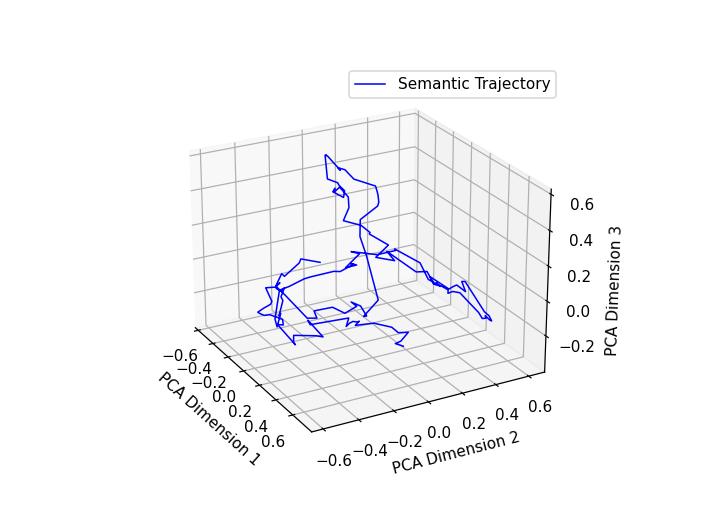

<IPython.core.display.Javascript object>


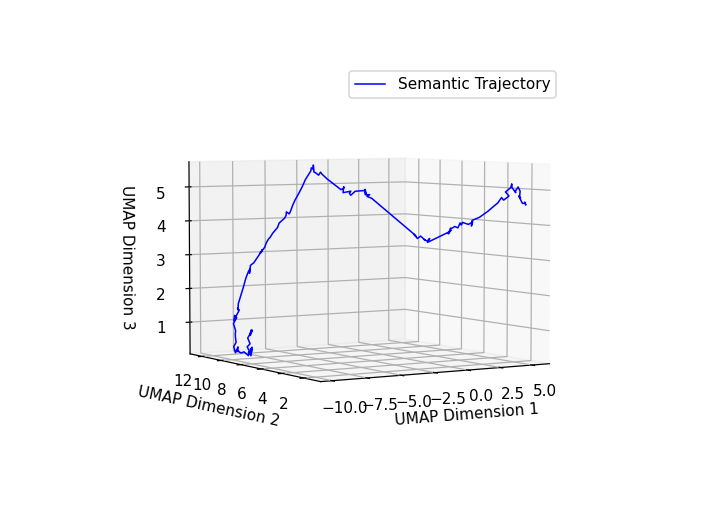

<IPython.core.display.Javascript object>


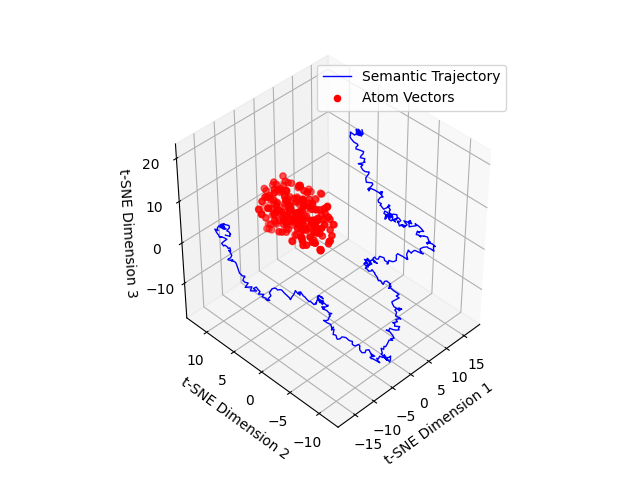

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Assuming you have sentence_embeddings and atom_vectors array
# Combine the embeddings into one array
combined_embeddings = np.vstack((sentence_embeddings, dictionary))

# Use t-SNE for dimensionality reduction to 3D on the combined set
tsne = TSNE(n_components=3, random_state=42)
reduced_combined = tsne.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and atom vectors
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced sentence embeddings (trajectory)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Plot the reduced atom vectors
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2], color='r', s=20, label='Atom Vectors')

# Set equal scaling for the 3D plot to maintain the aspect ratio
ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Add labels to the axes
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


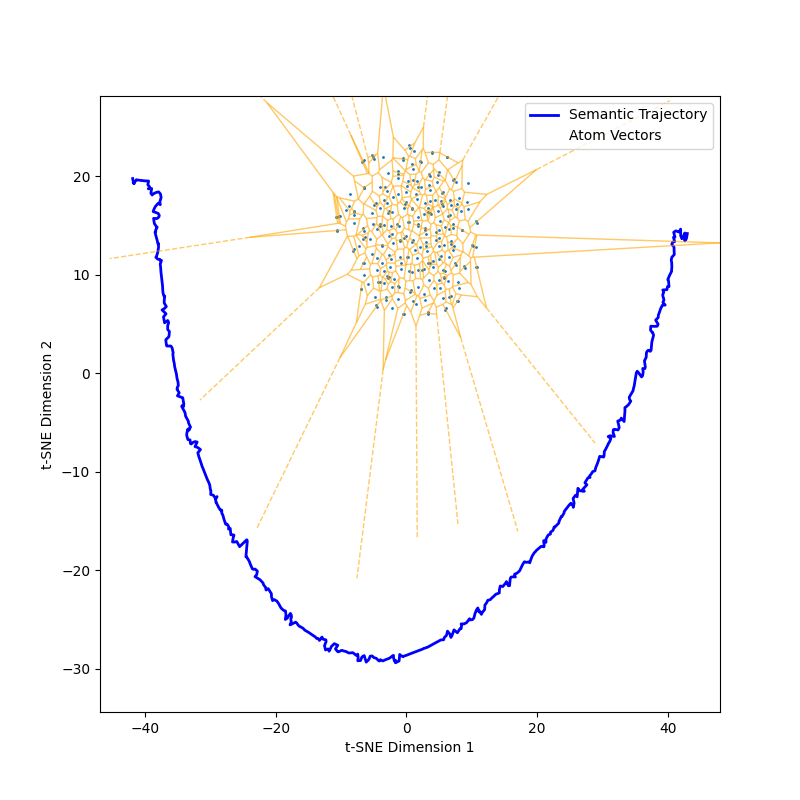

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE

# Assuming you have sentence_embeddings and dictionary (atom_vectors) array
# Combine the embeddings into one array
combined_embeddings = np.vstack((sentence_embeddings, dictionary))

# Use t-SNE for dimensionality reduction to 2D on the combined set
tsne = TSNE(n_components=2, random_state=42)
reduced_combined = tsne.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and dictionary (atom_vectors)
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# Create a Voronoi diagram in 2D using the reduced_vectors (dictionary vectors)
vor = Voronoi(reduced_vectors)

# Create a new plot for 2D projection
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the reduced sentence embeddings as a continuous trajectory (line)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', linewidth=2, label='Semantic Trajectory')

# Alternatively, plot the reduced sentence embeddings as individual points (scatter plot)
# ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', s=30, label='Semantic Trajectory')

# Plot the reduced atom vectors as a scatter plot
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], color='r', s=0, label='Atom Vectors')

# Plot the Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.6, point_size=2)

# Add labels to the axes
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

# Set axis limits based on the data
ax.set_xlim([reduced_combined[:, 0].min() - 5, reduced_combined[:, 0].max() + 5])
ax.set_ylim([reduced_combined[:, 1].min() - 5, reduced_combined[:, 1].max() + 5])

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [213]:
reduced_embeddings

array([[ 39.631947, -21.408522],
       [ 39.75002 , -21.556849],
       [ 39.963158, -21.262154],
       ...,
       [-38.706097, -19.826166],
       [-38.524643, -20.052017],
       [-38.69809 , -20.14541 ]], dtype=float32)

<IPython.core.display.Javascript object>


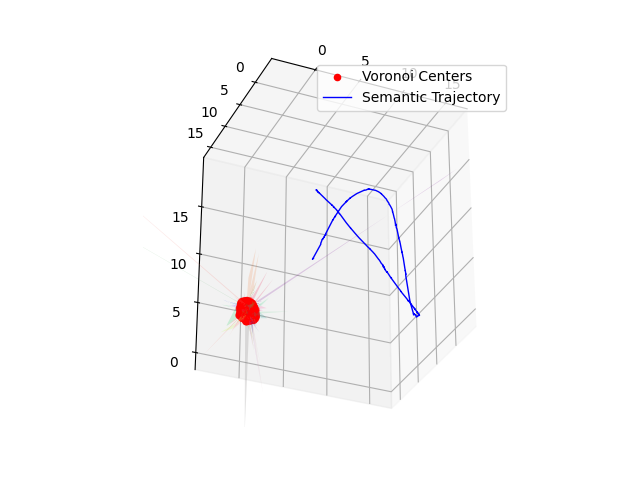

Voronoi indices for UMAP trajectory points: [137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137
 137 137 137 137 137 137 137 137 137 137 137 137 137 137 173 173 173 173
 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173
 173 173 173 173 173 173 173 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 210 210 210 210 210 210
 210 210 210 210 210 210 210 210 210 210 210 210 175 175 175 175 175 175
 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175
 175 175 175 175 175 196 175 196 196 196 196 196 196 196 196 196 196 196
 196 19

In [36]:
import numpy as np
import umap
from scipy.spatial import Voronoi#, cdist
from scipy.spatial.distance import cdist  # Corrected import
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

combined_embeddings = np.vstack((sentence_embeddings, atom_vectors))

# Use UMAP for dimensionality reduction to 3D on the combined set
umap_reducer = umap.UMAP(n_components=3)
reduced_combined = umap_reducer.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and atom vectors
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# No normalization to a sphere, we work on the actual UMAP 3D manifold

# Create a Voronoi diagram in 3D using the reduced_vectors
vor = Voronoi(reduced_vectors)

# Calculate Voronoi region for each point in the trajectory (reduced_embeddings)
voronoi_indices = np.argmin(cdist(reduced_embeddings, reduced_vectors), axis=1)

# Create a new plot with the Voronoi diagram on the 3D UMAP manifold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region_idx, region in enumerate(vor.regions):
    if not -1 in region and len(region) > 0:  # Ignore regions with unbounded vertices
        region_points = np.array([vor.vertices[i] for i in region])
        poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
        ax.add_collection3d(poly)

# Plot the original points (Voronoi centers)
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2], color='r', s=20, label='Voronoi Centers')

# Plot the trajectory points (sentence embeddings)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Set equal scaling for the 3D plot to maintain the aspect ratio
ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for UMAP trajectory points:", voronoi_indices)


<IPython.core.display.Javascript object>


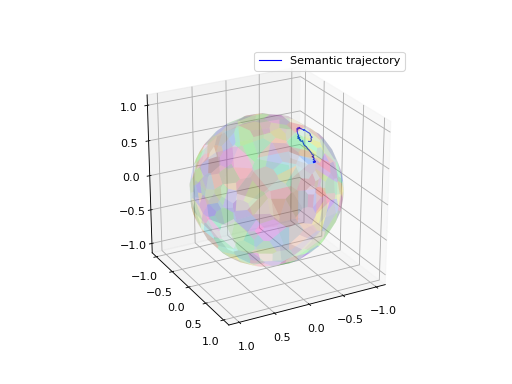

Voronoi indices for t-SNE trajectory points: [247 247 247 247 247 247 247 180 180  21  21 180  21  21  21 175 175 175
 175 175 175 175 175 175 175 175 175 175 175 100 100 100 100 100 100 100
 100 108 108 108 108 108 108 108 108 108 108 108  21  21  21  21  21]


In [180]:
import numpy as np
import umap
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Assuming you have sentence_embeddings and atom_vectors array
# Use UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_components=3)
reduced_embeddings = umap_reducer.fit_transform(sentence_embeddings)
reduced_vectors = umap_reducer.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms_vectors = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
#unit_vectors = reduced_vectors / norms_vectors DOES NOT WWORK WITH UMAP

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Create Voronoi diagram on the unit sphere (using unit_vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Calculate Voronoi region for each point in the trajectory (unit_embeddings)
# This is done by finding the closest unit_vector (Voronoi center) to each trajectory point
voronoi_indices = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Plot the path from sentence_embeddings
ax.plot(unit_embeddings[:, 0], unit_embeddings[:, 1], unit_embeddings[:, 2], color='blue', linewidth=1, label='Semantic trajectory')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for t-SNE trajectory points:", voronoi_indices)


In [144]:
print("Voronoi indices for trajectory points:", voronoi_indices)


Voronoi indices for trajectory points: [134 134 134 134 134 134 134 134 134 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 130 130 130 130 130 130 130 130 130 130 130 130 130
 130 130 130 130 130 130 130 130 219 219 219 219 219 219 219 219 219 219
 204 204   2   2   2   2   2   2   2   2   2   2   2   2 222  28  28  28
  28  94  94  94  94 174 174 174 174 174 174 174 174 174 174 230 215 227
 227 227 227 227 227 227 227 227 227 227 227 227 227  69  69  69  69  69
  69  69  69  69  69  69  69  69 236 236 236 236 226 226 184 184 184 184
 184 184 184 184 184 184 184 184 184 184 184 131 131 131 131 131 131 131
 131 131 131 131 131 131 131 131 124 124  24 209 209 209 209 209 209 209
 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 146
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 136 136 136 136 136 136 136 136 136 136 136
 136 136 136

In [38]:
ind=1
sentences = split_text_into_windows(df_processed['processed_text'].loc[ind], 128)
for idx, a in enumerate(voronoi_indices):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = [tokens[i].replace('ġ', '') for i in top_indices]
    print(a, most_similar_tokens)
    print(sentences[idx])

247 ['mina', 'alam', 'bei', 'sava', 'ari', 'sera', 'vila', 'ze', 'bai', 'maha']
all right so um im moderately bummed that selena just left the room uh i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all
247 ['mina', 'alam', 'bei', 'sava', 'ari', 'sera', 'vila', 'ze', 'bai', 'maha']
right so um im moderately bummed that selena just left the room uh i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fa

21 ['cc', 'mb', 'ms', 'bc', 'pc', 'cm', 'mp', 'md', 'pm', 'hs']
i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law
21 ['cc', 'mb', 'ms', 'bc', 'pc', 'cm', 'mp', 'md', 'pm', 'hs']
enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect wit

175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what
175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i proba

175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be
175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh 

100 ['gertrude', 'mary', 'ernest', 'edith', 'bertha', 'margaret', 'clara', 'george', 'eleanor', 'dorothy']
now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a
100 ['gertrude', 'mary', 'ernest', 'edith', 'bertha', 'margaret', 'clara', 'george', 'eleanor', 'dorothy']
i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or h

114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a fun anti its the intoxication of it is fun like alcohol without
114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them dow

114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a fun anti its the intoxication of it is fun like alcohol without the sloppiness without the ego i just uh uh sort of the
114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really s

KeyboardInterrupt: 

In [39]:
print("Voronoi indices for trajectory points using pca:", voronoi_indices_pca)


NameError: name 'voronoi_indices_pca' is not defined

In [40]:
print(voronoi_indices)

[247 247 247 247 247 247 247 247  21  21  21  21  21  21  21  21  21  21
  21  21  21  21  21  21  21 175  21 175 175 175 175 175 175 175 175 175
 175 175 175 175 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114
 114 114 114 114 114 162 162 162 162 162 162 162 162 179 179 179 179 179
 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179
 179 193 193 193 153 153 153 153 153 153 153 153 153 153 153 153 153 153
 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 191 191
 191 191 191 191 191 191 152 152  17  17  17  17  17  17  17  17  17  17
  17  17  17  17  17 106 106 106 106 106 106 184 184 226 184 226 226 226
 226 226 226 226 226 226 226 226 236 236 236 236 236 236 236 236 236 236
  89  89  89  89  89  89  89  89 237 237 237 237 237 237 237 237  69  69
  69  69  69  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30
  30 190 190 190 190 190 190 190 190 190 190 190 19

<IPython.core.display.Javascript object>


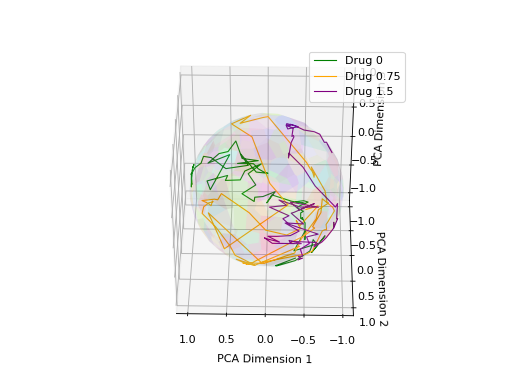

Voronoi indices for PCA sentence_embeddings: [168 113  55 113 155 155 163  35  22 238  31 118 118  42   8  53 107 158
 158  21 108 108 100 100  54 162 162 162 153 191 152 178 106 140 140  80
  80  89  10  68  69  30 241 104  94 167 167   2   2 219 219  20  20]
Voronoi indices for PCA combined embeddings (drugs): [228 228  37 228 243 243 243 243  92 243 243  85  85  85 149 149 149 149
 149 149 149 149 149  15  15 134  15 134 148 134 148 148 116 116 116 120
 120 189 189 116 196 165  66  66 138  98 165 138 143 160 189 160 189 189
 189 180 189 160 189 165  98 202 202 137 249 249 127 127 127 236 236 249
 125 125 125 125  85   2 242  75   3 242 242 204  85  85  63 107 107 107
 107 107 158 158 158 158 108 188 193 153 151 153 162  62 134 246  49 204
 243 243 102 102 102 102 102   9  53 107  63  63  63  85   5 174  51  61
  69  69  68 195  68 195  68  68  69  68 195 245  67  12  12 121 121 121
 144 201  92 244 244 244 244  48  48  48  65  12  12  12  38 234  38  16
 144 234 234 201 234 234 121 

In [188]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Step 1: Apply PCA to sentence_embeddings
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
unit_vectors = reduced_vectors / norms

reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Step 2: Combine embeddings from `vector_dict`
combined_embeddings = []
labels = []  # To track drug labels
for drug, embeddings in vector_dict.items():
    combined_embeddings.extend(embeddings)
    labels.extend([drug] * len(embeddings))  # Label the embeddings by drug

# Convert to numpy array
combined_embeddings = np.vstack(combined_embeddings)

# Step 3: Apply PCA to the combined embeddings from `vector_dict`
reduced_combined = pca.fit_transform(combined_embeddings)

# Step 4: Normalize the embeddings to the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings  # Normalized sentence embeddings

norms_combined = np.linalg.norm(reduced_combined, axis=1).reshape(-1, 1)
unit_combined = reduced_combined / norms_combined  # Normalized combined embeddings (from vector_dict)

# Step 5: Create Voronoi diagram on the unit sphere (assuming unit_vectors are the atom vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Step 6: Calculate Voronoi region for each point in the trajectory
voronoi_indices_pca = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)
voronoi_indices_combined = np.argmin(cdist(unit_combined, unit_vectors), axis=1)

# Step 7: Create the plot with Voronoi diagram and PCA-based trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.1, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the Voronoi vertices
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)
# Plot the paths for each drug condition from `vector_dict` (combined embeddings)
colors = {0: 'green', 0.75: 'orange', 1.5: 'purple'}  # Assign colors to each drug
for drug in vector_dict.keys():
    indices = [i for i, label in enumerate(labels) if label == drug]
    ax.plot(unit_combined[indices, 0], unit_combined[indices, 1], unit_combined[indices, 2], 
            color=colors[drug], linewidth=1, label=f'Drug {drug}')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Add labels to the axes
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')

# Optional: Add a legend to indicate different trajectories
ax.legend()

# Show the plot
plt.show()

# Print the Voronoi indices
print("Voronoi indices for PCA sentence_embeddings:", voronoi_indices_pca)
print("Voronoi indices for PCA combined embeddings (drugs):", voronoi_indices_combined)


<IPython.core.display.Javascript object>


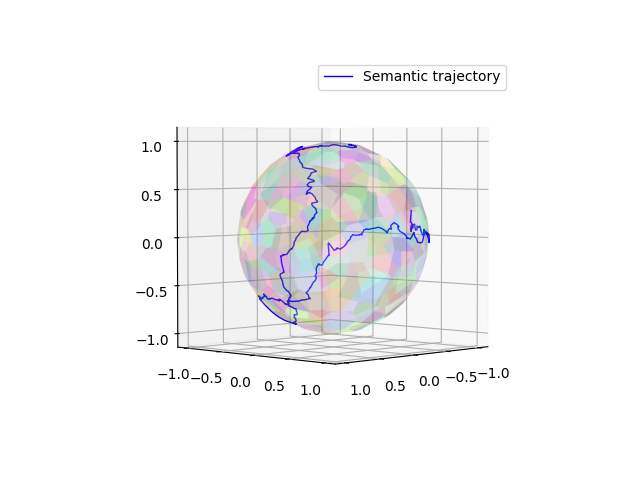

Voronoi indices for t-SNE trajectory points: [ 95  84  84  84  84  19  19  19  19  19  19  19  19  19  19  19  19  19
  19  19  19  19  19  19  19  19  19  84  84  84  84  84  84  84  84  84
  84  84  84  84  84  84  21  21  71  71  21  21  21  21  21  21  21 247
 247 247 247 247 247 148 148 148 148 148  60  60  60  60  60  60  60 159
 159 159 159 159 159 159 159 159 159 159 159 159 166 166 166 166 166 166
 196 196 196 196 196 196 196 196 196 196 196 196 196 196 162 162 162 162
 162 162 162 162 162 162 175 175 175 175 175 175 175 175 175 189 189 189
 189 189 189 189 189 189 189 189 143 143 143 143 143 143 143 143 143 143
 143 143 143 143 143 143 143  43  43  43  43  43  43  43  43  43  43  43
  43  43 185 185 185  43  43  43 190 190 190 190 190 190 190 195 195 195
 195 195 195 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236
 236 236 241 241 241 241 241 241 241 241 241 241 241 241 174 174 174 174
 174 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 1

In [52]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Assuming you have sentence_embeddings and atom_vectors array
# Use t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3)
reduced_embeddings = tsne.fit_transform(sentence_embeddings)
reduced_vectors = tsne.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms_vectors = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
unit_vectors = reduced_vectors / norms_vectors

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Create Voronoi diagram on the unit sphere (using unit_vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Calculate Voronoi region for each point in the trajectory (unit_embeddings)
# This is done by finding the closest unit_vector (Voronoi center) to each trajectory point
voronoi_indices = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Plot the path from sentence_embeddings
ax.plot(unit_embeddings[:, 0], unit_embeddings[:, 1], unit_embeddings[:, 2], color='blue', linewidth=1, label='Semantic trajectory')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for t-SNE trajectory points:", voronoi_indices)


<IPython.core.display.Javascript object>


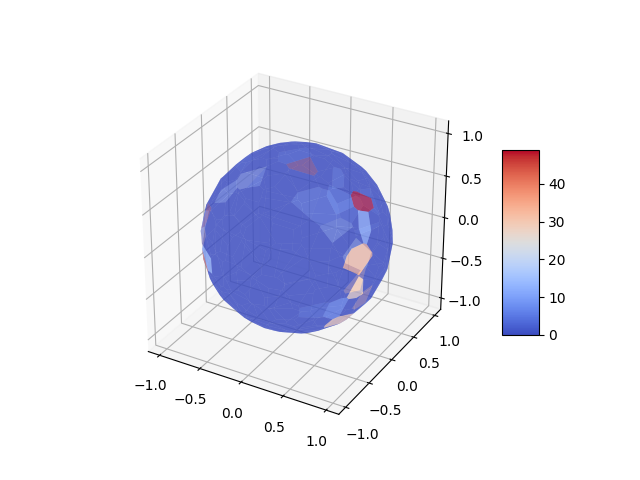

In [218]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import SphericalVoronoi, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

# Assuming you have sentence_embeddings array
# Apply the same PCA transformation to the sentence_embeddings
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Use KDTree to quickly find nearest Voronoi centroids for each embedding point
voronoi_tree = cKDTree(sv.vertices)
point_counts = np.zeros(len(sv.regions))

# Assign each embedding to the nearest Voronoi vertex
for point in unit_embeddings:
    distance, region_index = voronoi_tree.query(point)
    for i, region in enumerate(sv.regions):
        if region_index in region:
            point_counts[i] += 1
            break

# Normalize point counts for coloring
norm = plt.Normalize(vmin=point_counts.min(), vmax=point_counts.max())
colormap = cm.coolwarm

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions with colors based on point counts
for i, region in enumerate(sv.regions):
    region_points = np.array([sv.vertices[j] for j in region])
    color = colormap(norm(point_counts[i]))  # Color based on the number of points
    poly = Poly3DCollection([region_points], alpha=0.6, facecolor=color)
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Add a color bar to indicate intensity
mappable = cm.ScalarMappable(cmap=colormap, norm=norm)
mappable.set_array(point_counts)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


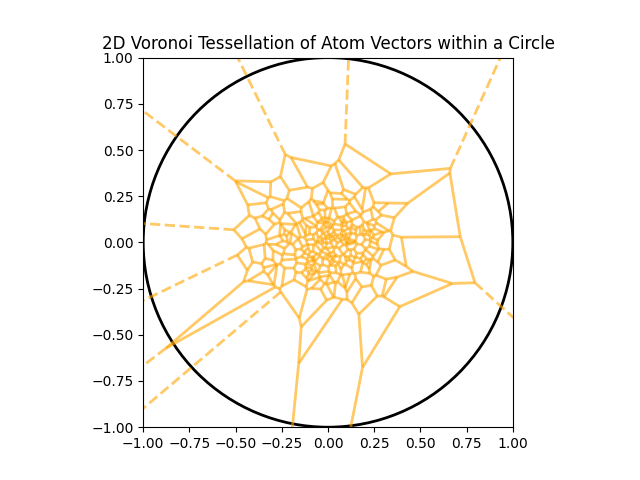

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_voronoi_tessellation_circle(dictionary, radius=1.0):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform PCA to reduce the dimensionality to 2D
    pca = PCA(n_components=2)
    embedding_matrix_2d = pca.fit_transform(atom_vectors)
    
    # Normalize the points to fit within a circle of the given radius
    embedding_matrix_2d = embedding_matrix_2d / np.max(np.linalg.norm(embedding_matrix_2d, axis=1)) * radius

    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=0)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=0)

    # Plot the circle to constrain the tessellation
    circle = plt.Circle((0, 0), radius, color='black', fill=False, lw=2)
    ax.add_artist(circle)

    # Set equal scaling and limits to ensure the circle is properly displayed
    ax.set_aspect('equal')
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    
    plt.title("2D Voronoi Tessellation of Atom Vectors within a Circle")
    plt.show()

# Example usage
# Assume your dictionary is something like: dictionary = {'a': np.array([...]), 'b': np.array([...]), ...}
plot_voronoi_tessellation_circle(dictionary)


<IPython.core.display.Javascript object>


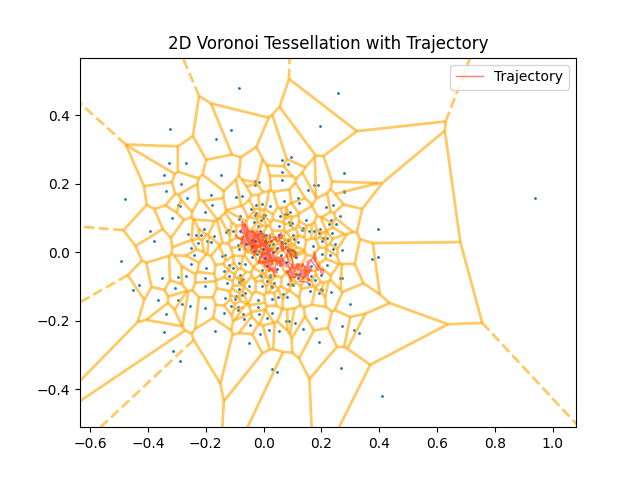

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform PCA to reduce the dimensionality to 2D for the atom vectors
    pca = PCA(n_components=2)
    embedding_matrix_2d = pca.fit_transform(atom_vectors)
    
    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=0)

    # Perform PCA to reduce sentence_embeddings to 2D
    sentence_embeddings_2d = pca.transform(sentence_embeddings)

    # Plot the 2D trajectory as a continuous path
    ax.plot(sentence_embeddings_2d[:, 0], sentence_embeddings_2d[:, 1], color='red', linewidth=1, alpha=0.5,label='Trajectory')

    # Add a legend
    ax.legend()

    plt.title("2D Voronoi Tessellation with Trajectory")
    plt.show()

# Example usage
# Assume 'dictionary' is your atom vectors and 'sentence_embeddings' is the list of vectors you want to plot as a path
plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings)


<IPython.core.display.Javascript object>


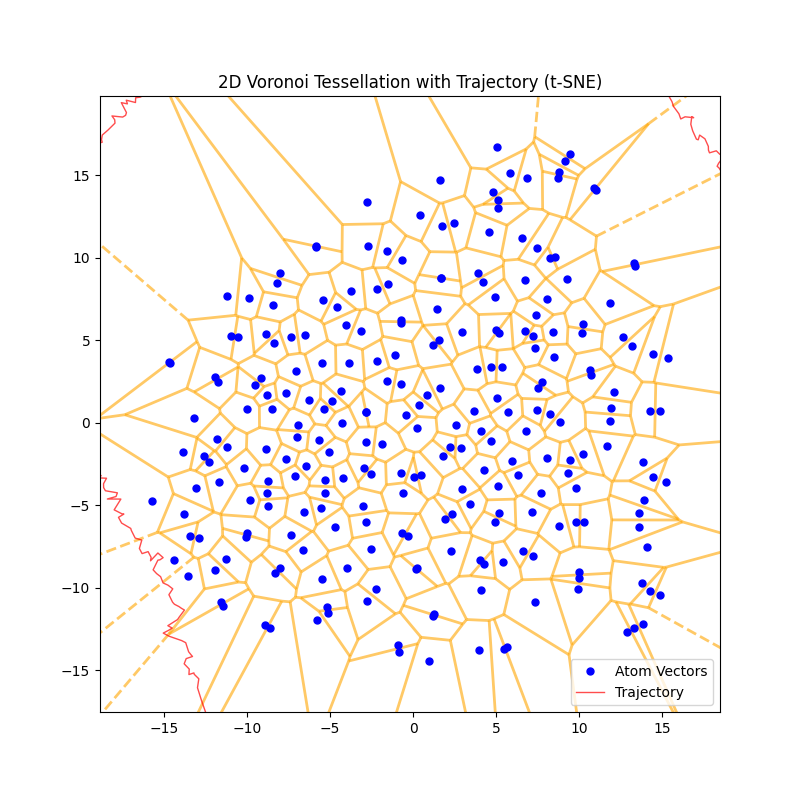

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE

def plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform t-SNE to reduce the dimensionality to 2D for the atom vectors
    tsne = TSNE(n_components=2, random_state=42)
    embedding_matrix_2d = tsne.fit_transform(atom_vectors)
    
    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=5, label='Atom Vectors')

    # Perform t-SNE to reduce sentence_embeddings to 2D
    sentence_embeddings_2d = tsne.fit_transform(sentence_embeddings)

    # Plot the 2D trajectory as a continuous path
    ax.plot(sentence_embeddings_2d[:, 0], sentence_embeddings_2d[:, 1], color='red', linewidth=1, alpha=0.7, label='Trajectory')

    # Add a legend
    ax.legend()

    plt.title("2D Voronoi Tessellation with Trajectory (t-SNE)")
    plt.show()

# Example usage
# Assume 'dictionary' is your atom vectors and 'sentence_embeddings' is the list of vectors you want to plot as a path
plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings)


In [36]:
def get_attention_weighted_null_sentence_embeddings(sentences, model, tokenizer, device='cpu',\
                                                    attention_scaling=1, attention_power=1):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True).to(device)
        token_ids = inputs['input_ids'].squeeze(0)
        # Extract hidden states and attention weights for the last 4 layers
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
            hidden_states = torch.mean(torch.stack(outputs.hidden_states[-4:]), dim=0).squeeze(0)
            attention_scores = torch.mean(torch.stack(outputs.attentions[-4:]), dim=0).squeeze(0)
            # Average attention scores across heads
            attention_weights = attention_scores.mean(dim=0)  # (seq_len, seq_len)
        # Compute attention-based weights for each token
        token_weights = attention_weights.sum(dim=0)  # Sum attention over all tokens to get per-token weight
        # Optional adjustments to the attention weights
        if attention_power != 1.0:
            token_weights = token_weights ** attention_power
        token_weights = token_weights / token_weights.sum()  # Normalize
        token_weights = token_weights.unsqueeze(-1)  # (seq_len, 1)
        sentence_embedding = (hidden_states * 1).sum(dim=0).cpu().numpy()
        embeddings.append(sentence_embedding)
    return np.array(embeddings)
def apply_attention_weighting_null(sentences, model, tokenizer, device='cpu',weighting=1, sub_pc=True):
    sentence_embeddings = get_attention_weighted_null_sentence_embeddings(sentences, model, tokenizer, device)
 # Subtract projection onto principal component
    return sentence_embeddings
def process_texts_null(df, model, tokenizer, atom_vectors, window='sentences',\
                  method='AW', windowsize=128):
    sentence_embeddings_column = []
    most_similar_atoms_column = []
    # Wrapping the loop with tqdm for progress tracking
    for text in tqdm(df['processed_text'], desc="Processing texts"):
        # Step 1: Split text into sentences
        if window=='window':
            sentences=split_text_into_windows(text, windowsize)
        elif window=='sentences':
            sentences = split_text_into_sentences(text)
        # Step 2: Get sentence embeddings using BERT
        sentence_embeddings = apply_attention_weighting_null(sentences, model,\
                                                        tokenizer,device,sub_pc=False)

        # Step 4: Append results
        most_similar_atoms = get_most_similar_atoms(sentence_embeddings, dictionary)
        sentence_embeddings_column.append(sentence_embeddings)
        most_similar_atoms_column.append(most_similar_atoms)
    # Add results to DataFrame
    df['sentence_embeddings'] = sentence_embeddings_column
    df['most_similar_atoms'] = most_similar_atoms_column

    return df

In [37]:
df_processed_null = process_texts_null(df.iloc[1:2], model, tokenizer, dictionary,window='window', method='AW')


Processing texts: 100%|██████████████████████████| 1/1 [03:56<00:00, 236.15s/it]
/tmp/ipykernel_213554/3310139949.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentence_embeddings'] = sentence_embeddings_column
/tmp/ipykernel_213554/3310139949.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['most_similar_atoms'] = most_similar_atoms_column


In [39]:
ind=1
sentences = split_text_into_windows(df_processed_null['processed_text'].loc[ind], 128)
for idx, a in enumerate(df_processed_null['most_similar_atoms'].loc[ind]):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = [tokens[i].replace('ġ', '') for i in top_indices]
    print(a, most_similar_tokens)
    print(sentences[idx])

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um i mean the whole day saturday with universal and the mechanical bull and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i mean the whole day saturday with universal and the mechanical bull and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all th

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole rea

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all t

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched wit

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas go

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fou

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fo

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really w

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was real

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day it

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there we

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty mu

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven drop

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested wh

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really ta

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like a

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was runni

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i w

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to g

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night p

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright s

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah yeah i tend to dwell on yeah yeah i tried to do something like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah yeah i tend to dwell on yeah yeah i tried to do something like that ah this week and ended up feeling like easily the worst i
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like

In [ ]:
df_processed.to_csv('./atomed_data.csv')